In [388]:
import warnings
warnings.filterwarnings("ignore")

In [389]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from scipy.stats import mode, pearsonr

## Question 1
Display the statistical values for each of the attributes, along with visualizations (e.g., histogram) of the distributions for each attribute. Are there any attributes that might require special treatment? If so, what special treatment might they require? 

### Pre-Processing Data


- retrieve labels from aggregate rock data 
    - retireve second column for labels


Rock Types Categories are 1 for Igneous, 2 for metamorphic, and 3 for sedimentary 

In [390]:

labels = pd.read_excel("data/aggregateRockData.xlsx", header = None)[[1]][:480]
labels = labels.rename(columns={1: 'Rock_Types'})
labels.head()


,Rock_Types
0,1
1,1
2,1
3,1
4,1


- retrieve values from features
    - columns 3: 14

In [391]:
column_headers = ["Token_number", "Angular_fragments", "Rounded _fragments",
                   "Straight_stripes", "Curved_stripes", "Physical_layers", "Veins", "Oily/shimmery_texture",
                   "Splotchy_texture", "Single_translucent_crystal", "Multiple_cubic_crystals", "Sandy_texture"]

features = pd.read_csv('data/feature_presence540.txt', delim_whitespace=True, header=None).iloc[:480, 2:14]
features.columns = column_headers
features.head()


,Token_number,Angular_fragments,Rounded _fragments,Straight_stripes,Curved_stripes,Physical_layers,Veins,Oily/shimmery_texture,Splotchy_texture,Single_translucent_crystal,Multiple_cubic_crystals,Sandy_texture
0,1,0.20,0.15,0.00,0.0,0.00,0.05,0.0,0.30,0.0,0.00,0.10
1,2,0.65,0.15,0.00,0.0,0.05,0.00,0.0,0.10,0.0,0.05,0.05
2,3,0.60,0.00,0.00,0.0,0.05,0.00,0.0,0.35,0.0,0.00,0.05
3,4,0.10,0.85,0.00,0.0,0.05,0.00,0.0,0.10,0.0,0.00,0.10
4,5,0.35,0.80,0.00,0.0,0.00,0.00,0.0,0.10,0.0,0.00,0.05


Merge rock labels onto features and adjust data types

In [392]:
DATA_DF = labels.merge(features, left_index=True, right_index=True)
DATA_DF

for col in DATA_DF.columns:
    # Convert to numeric if possible, otherwise keep the original type
    DATA_DF[col] = pd.to_numeric(DATA_DF[col], errors='ignore')
    
DATA_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Rock_Types                  480 non-null    int64  
 1   Token_number                480 non-null    int64  
 2   Angular_fragments           480 non-null    float64
 3   Rounded _fragments          480 non-null    float64
 4   Straight_stripes            480 non-null    float64
 5   Curved_stripes              480 non-null    float64
 6   Physical_layers             480 non-null    float64
 7   Veins                       480 non-null    float64
 8   Oily/shimmery_texture       480 non-null    float64
 9   Splotchy_texture            480 non-null    float64
 10  Single_translucent_crystal  480 non-null    float64
 11  Multiple_cubic_crystals     480 non-null    float64
 12  Sandy_texture               480 non-null    float64
dtypes: float64(11), int64(2)
memory usa

### Statistical Values

Basic Statistical Values

In [393]:
DATA_DF.describe()

,Rock_Types,Token_number,Angular_fragments,Rounded _fragments,Straight_stripes,Curved_stripes,Physical_layers,Veins,Oily/shimmery_texture,Splotchy_texture,Single_translucent_crystal,Multiple_cubic_crystals,Sandy_texture
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,2.000000,8.500000,0.084479,0.080208,0.067729,0.042292,0.165146,0.052396,0.144479,0.141458,0.031667,0.025104,0.119854
std,0.817348,4.614582,0.193996,0.197648,0.194792,0.160970,0.216635,0.102676,0.265689,0.168222,0.135647,0.112153,0.173149
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,4.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,8.500000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.100000,0.000000,0.000000,0.050000
75%,3.000000,12.250000,0.050000,0.050000,0.000000,0.000000,0.212500,0.050000,0.100000,0.200000,0.000000,0.000000,0.150000
max,3.000000,16.000000,1.000000,1.000000,1.000000,1.000000,0.950000,0.900000,1.000000,0.950000,1.000000,1.000000,1.000000


Check Null and Missing Values

In [394]:
DATA_DF.isnull().sum()

Rock_Types                    0
Token_number                  0
Angular_fragments             0
Rounded _fragments            0
Straight_stripes              0
Curved_stripes                0
Physical_layers               0
Veins                         0
Oily/shimmery_texture         0
Splotchy_texture              0
Single_translucent_crystal    0
Multiple_cubic_crystals       0
Sandy_texture                 0
dtype: int64

Plotting Histograms

In [395]:
COLORMAP = plt.cm.inferno

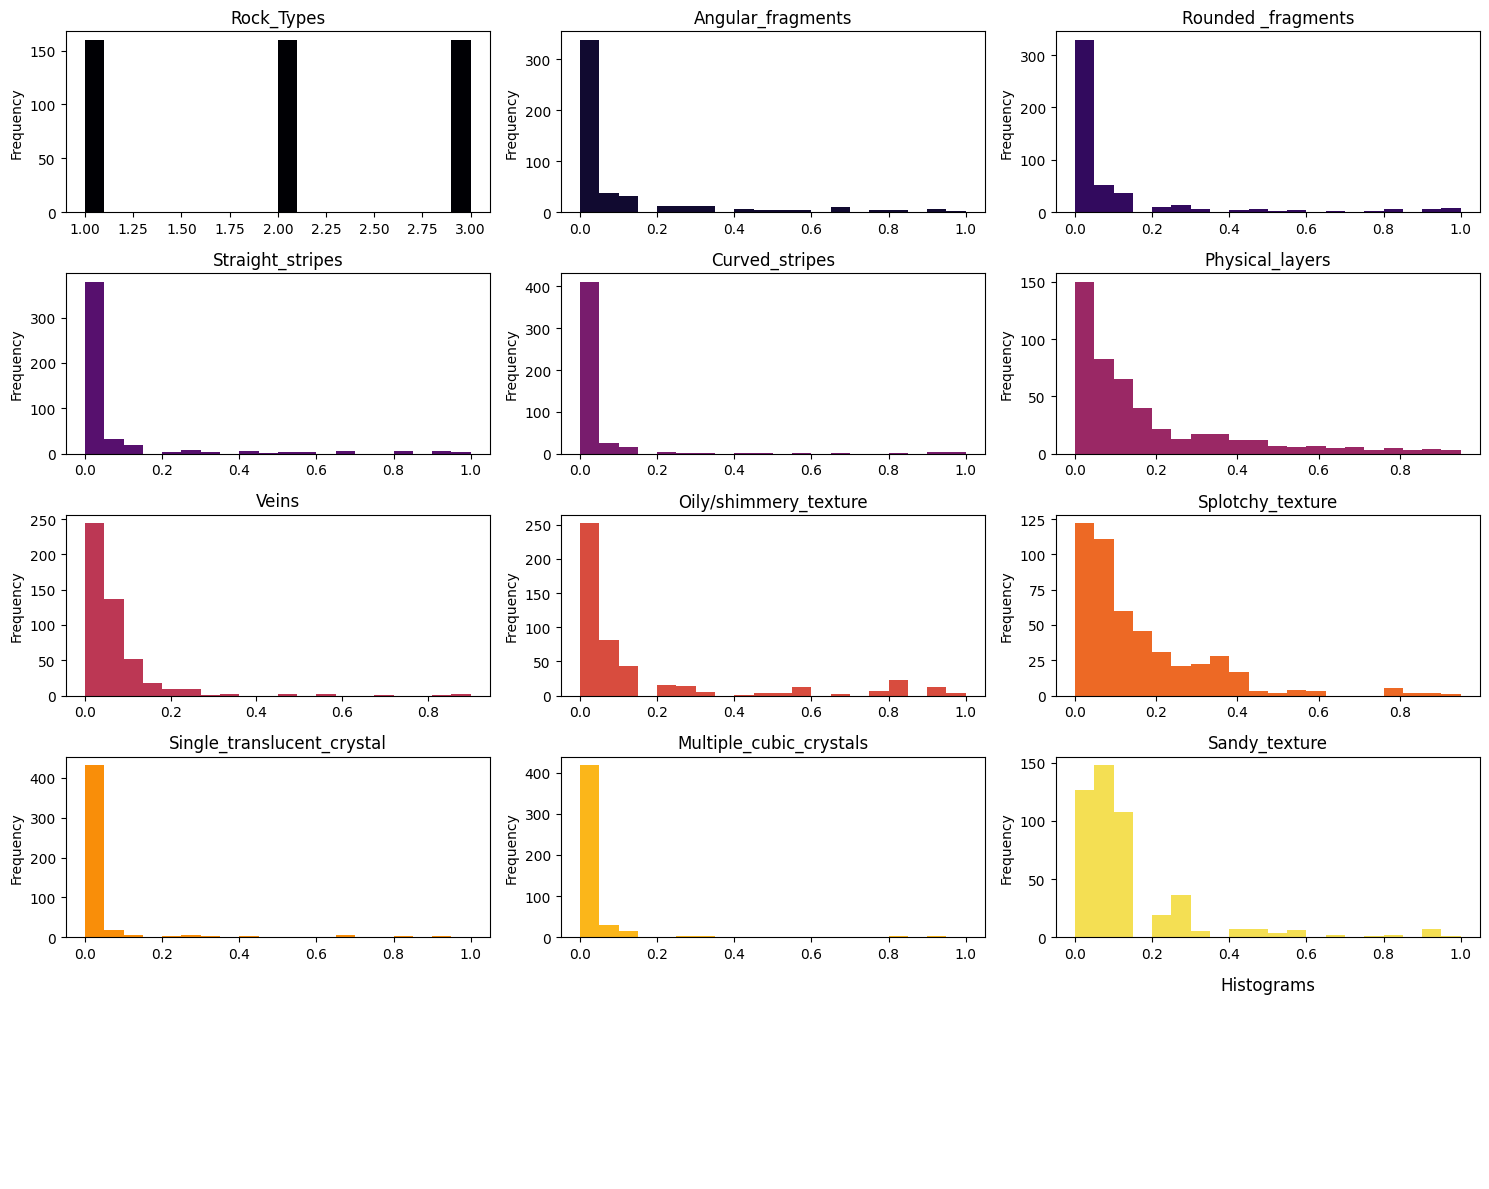

In [396]:
filtered_data = DATA_DF.drop(columns=['Token_number'])

fig, axes = plt.subplots(5, 3, figsize=(15, 12)) 
axes = axes.flatten()

for i, (col, ax) in enumerate(zip(filtered_data.columns, axes)):
    color = COLORMAP(i / len(filtered_data.columns))  
    filtered_data[col].plot.hist(ax=ax, color=color, bins=20, grid=False)
    ax.set_title(col)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.title('Histograms')
plt.tight_layout()
plt.show()

Plotting Box and Whiskers for features 

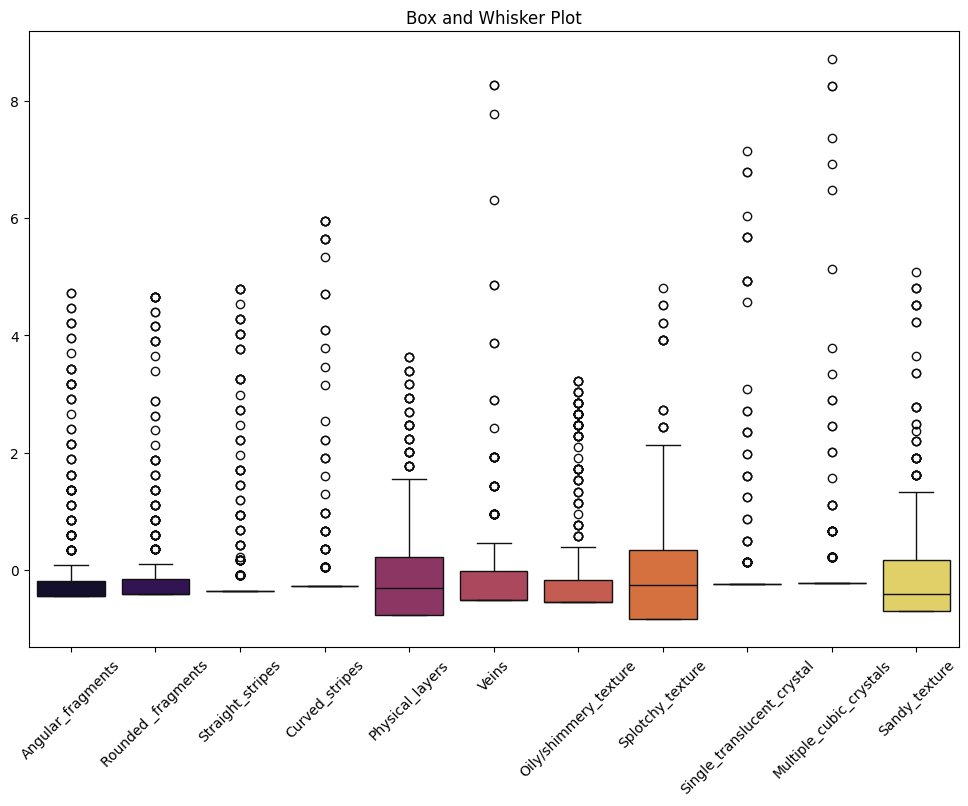

In [456]:
filtered_data = DATA_DF.drop(columns=['Rock_Types', 'Token_number'])

palette = sns.color_palette("inferno", n_colors=len(filtered_data.columns))

plt.figure(figsize=(12, 8))
sns.boxplot(data=filtered_data, palette=palette)
plt.xticks(rotation=45)  
plt.title("Box and Whisker Plot")
plt.show()

### Observations

In the dataset, the target variable, "Rock Type," is evenly distributed among the three categories. All predictive features range from 0 to 1, exhibiting positively skewed distributions which may need to be scaled using Standard Scaler. Additionally, there are no null values, and all variables except the target are continuous so no label encoding is needed.

# Question 2
Analyze and discuss the relationships between the data attributes and between the data attributes and labels. This involves computing the Pearson Correlation Coefficient (PCC) and generating scatter plots.


In [398]:

TARGET_VARIABLE = 'Rock_Types'
FEATURES = DATA_DF.columns.drop([TARGET_VARIABLE, 'Token_number'])

### Scatter Plots 

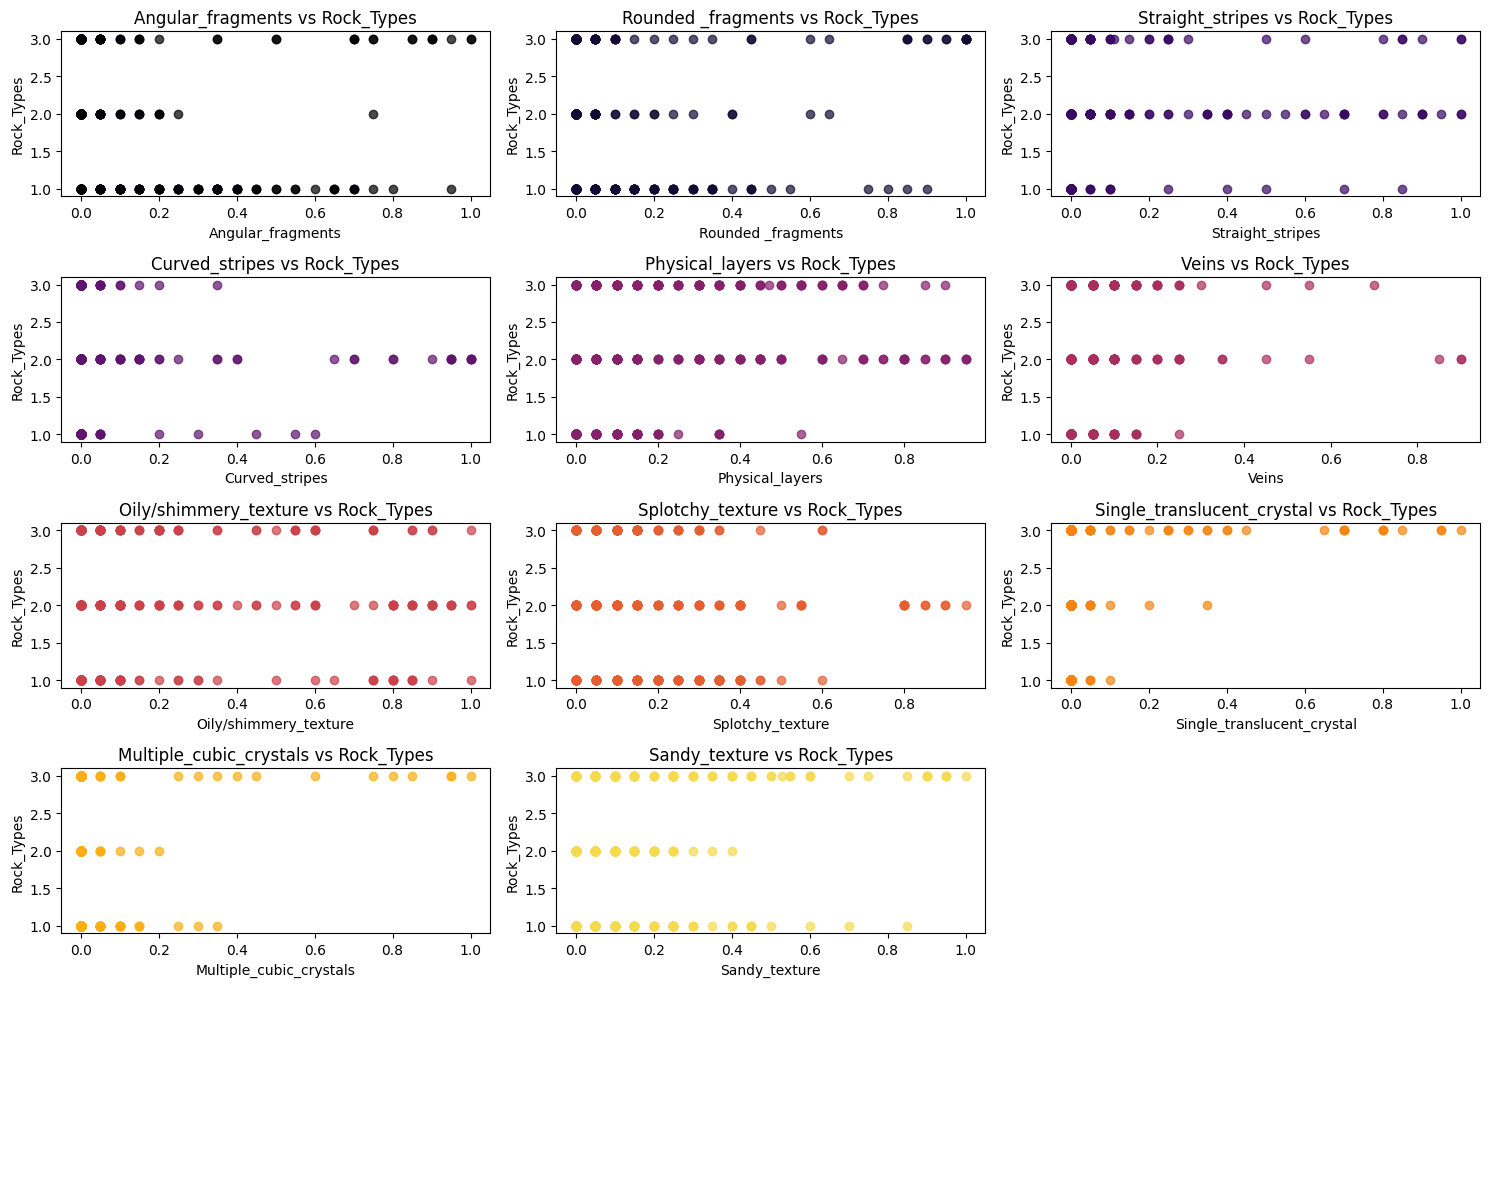

In [399]:

fig, axes = plt.subplots(5, 3, figsize=(15,12))
axes = axes.flatten()

for i, feature in enumerate(FEATURES):
    ax = axes[i]
    color = COLORMAP(i / len(filtered_data.columns))  
    ax.scatter(DATA_DF[feature], DATA_DF[TARGET_VARIABLE], alpha=0.7, color=color)
    ax.set_xlabel(feature)
    ax.set_ylabel(TARGET_VARIABLE)
    ax.set_title(f"{feature} vs {TARGET_VARIABLE}")

# Hide any unused subplots if there are fewer features than subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

### Pearson Correlation

Testing the pearson correlation of all feature values compared to the target column, sorting each value by the highest absolute error

In [400]:

results = []
for i in FEATURES:
    stat, p_value = pearsonr(DATA_DF[i], DATA_DF[TARGET_VARIABLE])
    results.append({
        'Target': TARGET_VARIABLE,
        'Compared_Column': i,
        'Statistic': stat,
        'p_value': p_value

    })
            
stat = pd.DataFrame(results).sort_values(by='Statistic', key=abs, ascending=False)
print("Pearson Correlation of all features compared to target value Rock_Type")
stat

Pearson Correlation of all features compared to target value Rock_Type


,Target,Compared_Column,Statistic,p_value
4,Rock_Types,Physical_layers,0.266699,2.926048e-09
8,Rock_Types,Single_translucent_crystal,0.258910,8.608453e-09
7,Rock_Types,Splotchy_texture,-0.229273,3.818033e-07
5,Rock_Types,Veins,0.140553,2.024196e-03
10,Rock_Types,Sandy_texture,0.139845,2.133740e-03
0,Rock_Types,Angular_fragments,-0.122447,7.235725e-03
9,Rock_Types,Multiple_cubic_crystals,0.113872,1.254507e-02
2,Rock_Types,Straight_stripes,0.077495,8.989524e-02
3,Rock_Types,Curved_stripes,-0.017454,7.028771e-01
1,Rock_Types,Rounded _fragments,0.017446,7.030119e-01


### Correlation Matrix

<Axes: >

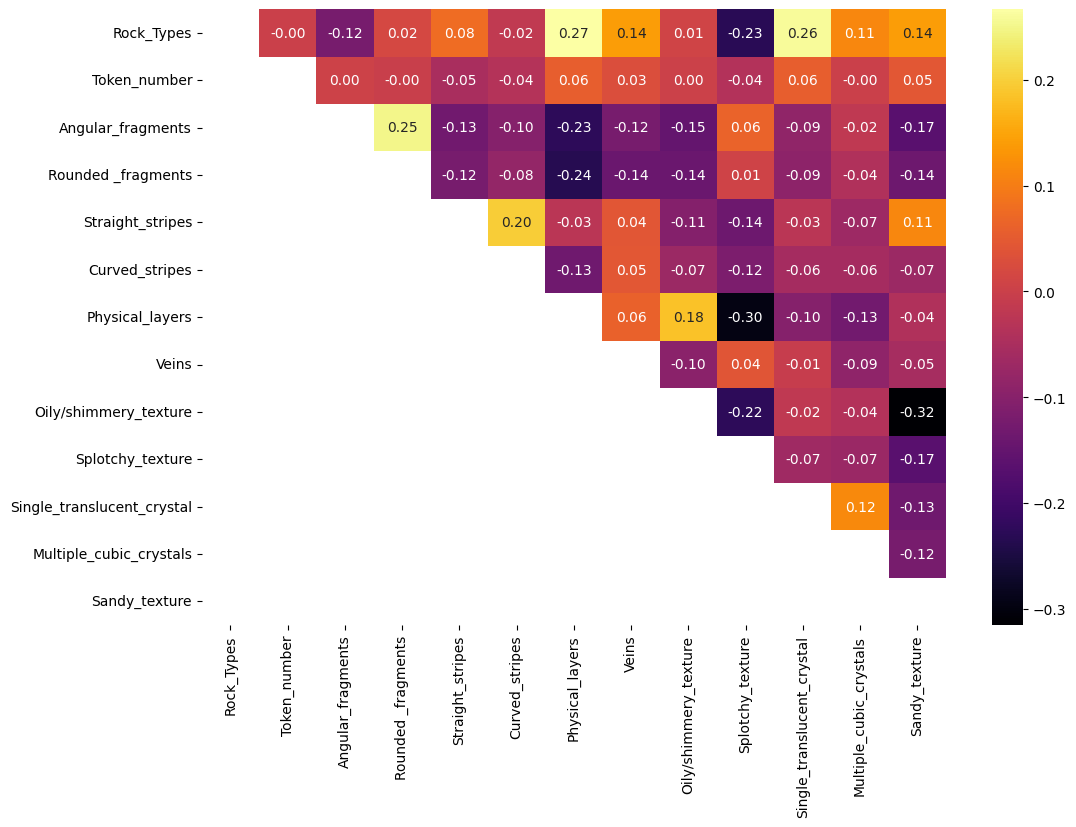

In [401]:
# PCC matrix for attributes and labels
correlation_matrix = DATA_DF.corr()
mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap=COLORMAP)

### Observations

From scatter plots, Pearson correlation scores, and the correlation matrix, we observed that the features with the highest absolute correlation coefficients to our target variable are the physical layer attributes and single translucent crystal characteristics. These values are also validated by p values less than .05. 

# Question 3
For training data, use token numbers 1-10, for validation 11 to 13, and for testing 14 to 16 (each of the 30 rock subtypes has 16 token numbers).

### Splitting

Scale Data 

In [402]:
scaler = StandardScaler()
DATA_DF[FEATURES] = scaler.fit_transform(DATA_DF[FEATURES])

Split data into Train-Test-Validate sets

In [403]:
# Train Test Validate Split

train_tokens = [ x for x in range(1, 11)]
validate_tokens = [x for x in range(11, 14)]
test_tokens = [x for x in range(14, 17)]

train_data = DATA_DF[DATA_DF["Token_number"].isin(train_tokens)]
test_data = DATA_DF[DATA_DF["Token_number"].isin(test_tokens)]
validate_data = DATA_DF[DATA_DF["Token_number"].isin(validate_tokens)]

Splitting X and Y labels

In [404]:
X_train, y_train = train_data[FEATURES], train_data[TARGET_VARIABLE]
X_test, y_test = test_data[FEATURES], test_data[TARGET_VARIABLE]
X_validate, y_validate = validate_data[FEATURES], validate_data[TARGET_VARIABLE]

Checking the amount of data in each split

In [405]:
print("----------- Shape ------------")
print("training data: ", train_data.shape)
print("validate data: ", validate_data.shape)
print("test data: ", test_data.shape)

print("\n----------- Proportion ------------")
print(f"Training Data: {len(train_data)/ len(DATA_DF):.3f}%")
print(f"Validation Data: {len(validate_data)/ len(DATA_DF):.3f}%")
print(f"Testing Data: {len(test_data)/ len(DATA_DF):.3f}")

----------- Shape ------------
training data:  (300, 13)
validate data:  (90, 13)
test data:  (90, 13)

----------- Proportion ------------
Training Data: 0.625%
Validation Data: 0.188%
Testing Data: 0.188


### Check validity of splits

Ensure that each target class is represented in each split

In [406]:

print("Target distribution in training data: ")
print(train_data[TARGET_VARIABLE].value_counts())

print("Target distribution in test data: ")
print(test_data[TARGET_VARIABLE].value_counts())

print("Target validate in training data: ")
print(validate_data[TARGET_VARIABLE].value_counts())

Target distribution in training data: 
Rock_Types
1    100
2    100
3    100
Name: count, dtype: int64
Target distribution in test data: 
Rock_Types
1    30
2    30
3    30
Name: count, dtype: int64
Target validate in training data: 
Rock_Types
1    30
2    30
3    30
Name: count, dtype: int64


Checking the box and whisker plots for each column for each split 

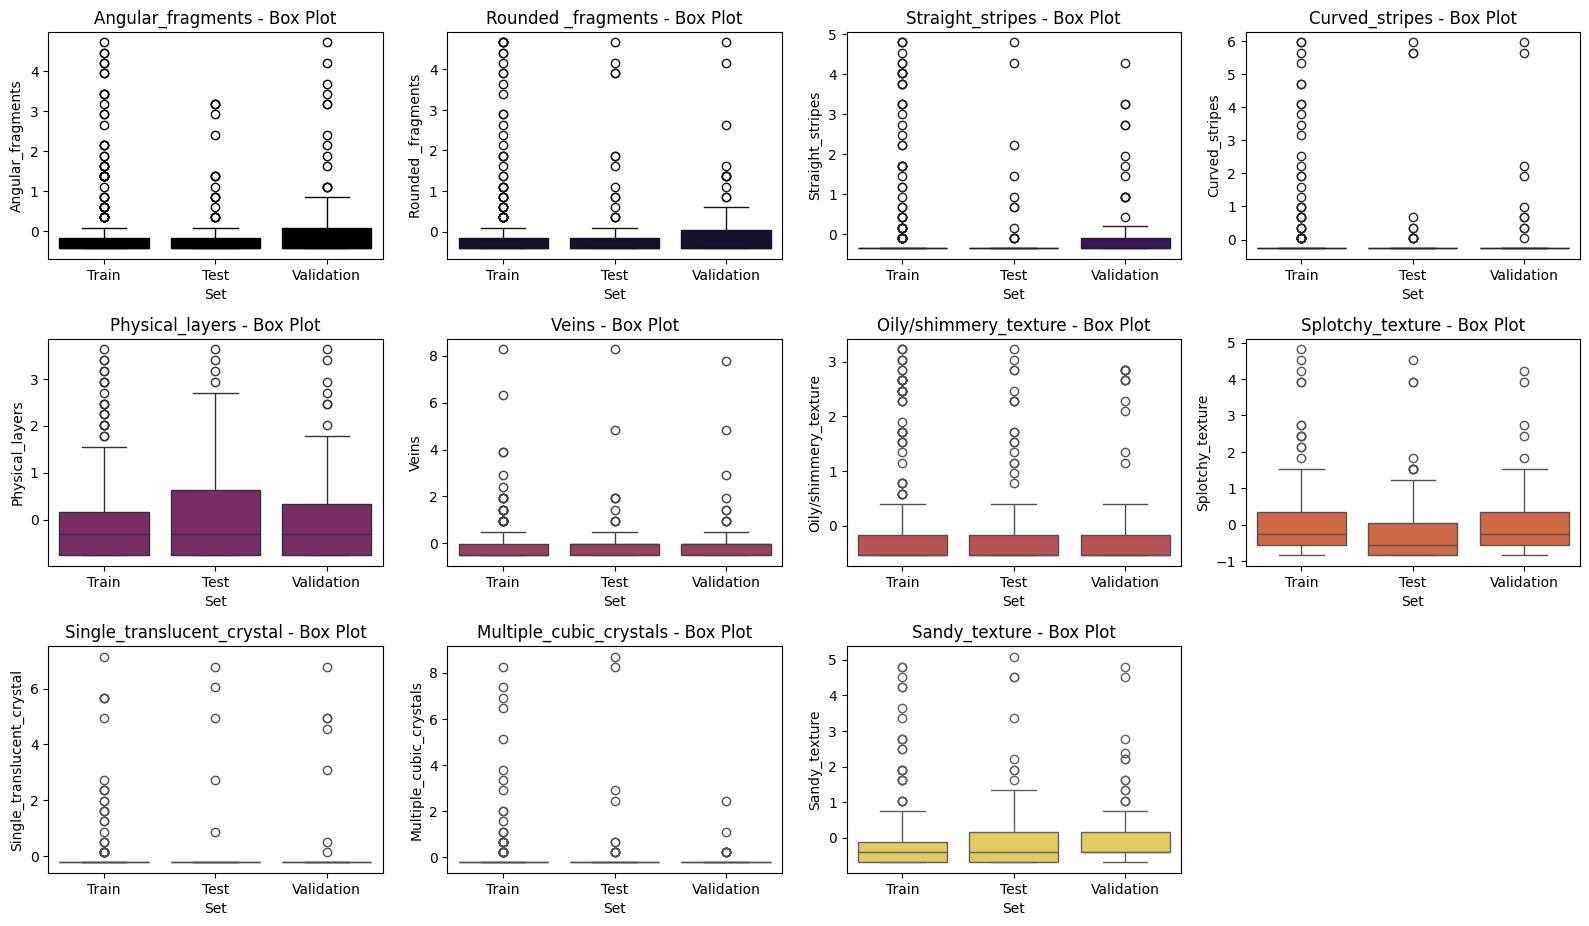

In [407]:
train_data["Set"] = "Train"
test_data["Set"] = "Test"
validate_data["Set"] = "Validation"
combined_data = pd.concat([train_data, test_data, validate_data])

# Drop 'Token_number' column if it's not needed
combined_data = combined_data.drop(columns=["Token_number", "Rock_Types"])

plt.figure(figsize=(16, 12))
for i, column in enumerate(combined_data.columns[:-1]):  
    plt.subplot(4, 4, i + 1)
    color = COLORMAP(i / len(filtered_data.columns))  
    sns.boxplot(x="Set", y=column, data=combined_data, color=color)
    plt.title(f"{column} - Box Plot")

plt.tight_layout()
plt.show()

Check the mean and std of each column for each split

In [408]:
summary_df = pd.DataFrame()

for column in DATA_DF.columns:
    if column != "Token_number":
        stats = {
            f"train_mean": train_data[column].mean(),
            f"train_std": train_data[column].std(),
            f"test_mean": test_data[column].mean(),
            f"test_std": test_data[column].std(),
            f"validate_mean": validate_data[column].mean(),
            f"validate_std": validate_data[column].std()
        }
        summary_df = pd.concat([summary_df, pd.DataFrame(stats, index=[column])])

summary_df.index.name = 'Column'
summary_df.reset_index(inplace=True)

summary_df

,Column,train_mean,train_std,test_mean,test_std,validate_mean,validate_std
0,Rock_Types,2.000000,0.817861,2.000000,0.821071,2.000000,0.821071
1,Angular_fragments,-0.025693,0.989579,-0.054647,0.866764,0.140291,1.151926
2,Rounded _fragments,0.003165,1.027976,-0.009496,1.024310,-0.001055,0.890938
3,Straight_stripes,0.031369,1.074117,-0.136791,0.806667,0.032226,0.918289
4,Curved_stripes,0.013733,0.986464,-0.021161,1.087949,-0.024616,0.968871
5,Physical_layers,-0.041492,0.952191,0.122550,1.112774,0.015756,1.042956
6,Veins,-0.033108,0.898548,0.052472,1.166730,0.057888,1.144407
7,Oily/shimmery_texture,0.004474,0.996713,0.008242,1.013430,-0.023156,1.013922
8,Splotchy_texture,0.019092,0.981341,-0.088021,1.070651,0.024382,1.000975
9,Single_translucent_crystal,-0.023369,0.878159,0.016399,1.158722,0.061498,1.205787


### Observations

When dividing the data into a 63/19/19 Train/Validation/Test split, we observed that following the provided indexing instructions yielded a fairly representative dataset. We validated this by comparing statistics like mean and standard deviation, as well as generating box-and-whisker plots for each column across all splits. The results were consistent across splits, with only minor variations due to expected noise.

# Question 4 
Train different classifiers and tweak the hyperparameters to improve performance (you can use the grid search if you want or manually try different values). Report training, validation and testing performance (classification accuracy, precision, recall and F1 score) and discuss the impact of the hyperparameters (use markdown cells in Jupyter Notebook to clearly indicate each solution):


### Multinomial Logistic Regression (Softmax Regression); hyperparameters to explore: C, solver, max number of iterations. 

In [409]:
# Modelling

logreg = LogisticRegression(fit_intercept = True, multi_class = "multinomial", max_iter = 50)

logreg.fit(X_train, y_train)

# Evaluating on training data
train_preds = logreg.predict(X_train)
print("---------------------- Training Metrics ----------------------")
print("Accuracy: ", round(accuracy_score(y_train, train_preds), 3))
print("Precision: ", precision_score(y_train, train_preds, average = "macro").round(3))
print("Recall: ", recall_score(y_train, train_preds, average = "macro").round(3))
print("F1 Score: ", f1_score(y_train, train_preds, average = "macro").round(3))

# Evaluating on validation data
validate_preds = logreg.predict(X_validate)
print("---------------------- Validation Metrics ----------------------")
print("Accuracy: ", round(accuracy_score(y_validate, validate_preds), 3))
print("Precision: ", precision_score(y_validate, validate_preds, average = "macro").round(3))
print("Recall: ", recall_score(y_validate, validate_preds, average = "macro").round(3))
print("F1 Score: ", f1_score(y_validate, validate_preds, average = "macro").round(3))

---------------------- Training Metrics ----------------------
Accuracy:  0.67
Precision:  0.671
Recall:  0.67
F1 Score:  0.67
---------------------- Validation Metrics ----------------------
Accuracy:  0.756
Precision:  0.762
Recall:  0.756
F1 Score:  0.751


In [410]:
# Hyperparameters tuning

num_iterations, cs, solvers = [x for x in range(10, 51, 2)], [round(i * 0.01, 1) for i in range(10, 101, 10)], ["lbfgs", "newton-cg", "sag", "saga"] #other solvers are not supported for multinomial regression.

print("Number of iterations: ", num_iterations)
print("C: ", cs)
print("Solvers: ", solvers)

Number of iterations:  [10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]
C:  [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
Solvers:  ['lbfgs', 'newton-cg', 'sag', 'saga']


In [411]:
grid_df = pd.DataFrame(columns = ["Number of Iterations", "Train Precision", "Train Recall", "Train F1 Score", "Train Accuracy", 
                                  "Validation Precision", "Validation Recall", "Validation F1 Score", "Validation Accuracy"])

for num_itr in num_iterations:

    logreg = LogisticRegression(fit_intercept = True, multi_class = "multinomial", max_iter = num_itr)

    logreg.fit(X_train, y_train)

    train_preds = logreg.predict(X_train)

    train_pr = precision_score(y_train, train_preds, average = "macro").round(3)
    train_rec = recall_score(y_train, train_preds, average = "macro").round(3)
    train_f1_score = f1_score(y_train, train_preds, average = "macro").round(3)
    train_acc = round(accuracy_score(y_train, train_preds,), 3)

    validate_preds = logreg.predict(X_validate)

    valid_pr = precision_score(y_validate, validate_preds, average = "macro").round(3)
    valid_rec = recall_score(y_validate, validate_preds, average = "macro").round(3)
    valid_f1_score = f1_score(y_validate, validate_preds, average = "macro").round(3)
    valid_acc = round(accuracy_score(y_validate, validate_preds,), 3)

    curr_row = [num_itr, train_pr, train_rec, train_f1_score, train_acc, valid_pr, valid_rec, valid_f1_score, valid_acc]

    grid_df.loc[len(grid_df)] = curr_row

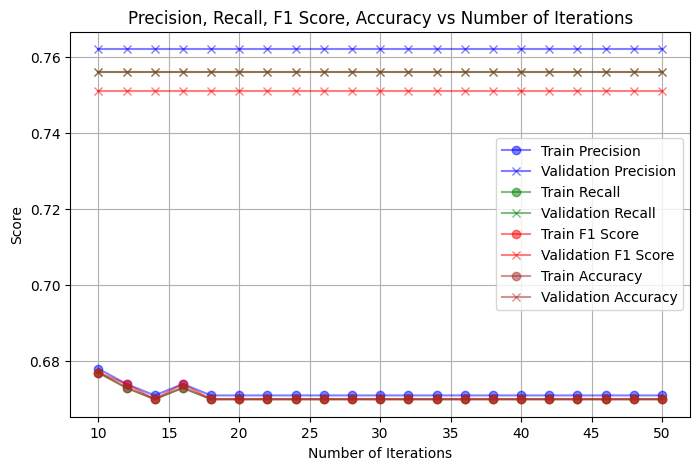

In [412]:
# Finding the best number of iterations

train_precision = grid_df["Train Precision"]
valid_precision = grid_df["Validation Precision"]
train_recall = grid_df["Train Recall"]
train_acc = grid_df["Train Accuracy"]

valid_recall = grid_df["Validation Recall"]
train_f1_score = grid_df["Train F1 Score"]
valid_f1_score = grid_df["Validation F1 Score"]
valid_acc = grid_df["Validation Accuracy"]

def create_combined_plot(x, train_precision, valid_precision, train_recall, valid_recall, train_f1_score, valid_f1_score, train_acc, valid_acc, parameter):

    plt.figure(figsize = (8, 5))

    # Precision
    plt.plot(x, train_precision, color = 'blue', label = 'Train Precision', marker = 'o', alpha = 0.5)
    plt.plot(x, valid_precision, color = 'blue', label = 'Validation Precision', marker = 'x', alpha = 0.5)

    # Recall
    plt.plot(x, train_recall, color = 'green', label = 'Train Recall', marker = 'o', alpha = 0.5)
    plt.plot(x, valid_recall, color = 'green', label = 'Validation Recall', marker = 'x', alpha = 0.5)

    # F1 Score
    plt.plot(x, train_f1_score, color = 'red', label = 'Train F1 Score', marker = 'o', alpha = 0.5)
    plt.plot(x, valid_f1_score, color = 'red', label = 'Validation F1 Score', marker = 'x', alpha = 0.5)

    # Accuracy
    plt.plot(x, train_acc, color = 'brown', label = 'Train Accuracy', marker = 'o', alpha = 0.5)
    plt.plot(x, valid_acc, color = 'brown', label = 'Validation Accuracy', marker = 'x', alpha = 0.5)

    plt.xlabel('{0}'.format(parameter))
    plt.ylabel('Score')
    plt.title('Precision, Recall, F1 Score, Accuracy vs {0}'.format(parameter))
    plt.legend(loc = 'best')
    plt.grid(True)

    plt.show()

create_combined_plot(grid_df["Number of Iterations"], train_precision, valid_precision, train_recall, valid_recall, train_f1_score, valid_f1_score, train_acc, valid_acc, "Number of Iterations")

We can take number of iterations as 30 as the metrics saturate after that.

In [413]:
grid_df = pd.DataFrame(columns = ["Number of Iterations", "Solver", 
                                  "Train Precision", "Train Recall", "Train F1 Score", "Train Accuracy", 
                                  "Validation Precision", "Validation Recall", "Validation F1 Score", "Validation Accuracy"])


# for c in cs:
for sol in solvers:

    logreg = LogisticRegression(fit_intercept = True, multi_class = "multinomial", max_iter = 30, solver = sol)

    logreg.fit(X_train, y_train)

    train_preds = logreg.predict(X_train)

    train_pr = precision_score(y_train, train_preds, average = "macro").round(3)
    train_rec = recall_score(y_train, train_preds, average = "macro").round(3)
    train_f1_score = f1_score(y_train, train_preds, average = "macro").round(3)
    train_acc = round(accuracy_score(y_train, train_preds,), 3)

    validate_preds = logreg.predict(X_validate)

    valid_pr = precision_score(y_validate, validate_preds, average = "macro").round(3)
    valid_rec = recall_score(y_validate, validate_preds, average = "macro").round(3)
    valid_f1_score = f1_score(y_validate, validate_preds, average = "macro").round(3)
    valid_acc = round(accuracy_score(y_validate, validate_preds,), 3)

    curr_row = [30, sol, train_pr, train_rec, train_f1_score, train_acc, valid_pr, valid_rec, valid_f1_score, valid_acc]

    grid_df.loc[len(grid_df)] = curr_row

In [414]:
grid_df

,Number of Iterations,Solver,Train Precision,Train Recall,Train F1 Score,Train Accuracy,Validation Precision,Validation Recall,Validation F1 Score,Validation Accuracy
0,30,lbfgs,0.671,0.67,0.67,0.67,0.762,0.756,0.751,0.756
1,30,newton-cg,0.671,0.67,0.67,0.67,0.762,0.756,0.751,0.756
2,30,sag,0.670,0.67,0.67,0.67,0.762,0.756,0.751,0.756
3,30,saga,0.671,0.67,0.67,0.67,0.762,0.756,0.751,0.756


All the solvers are giving exactly the same metrics.

In [415]:
grid_df = pd.DataFrame(columns = ["Number of Iterations", "Solver", "C",
                                  "Train Precision", "Train Recall", "Train F1 Score", "Train Accuracy", 
                                  "Validation Precision", "Validation Recall", "Validation F1 Score", "Validation Accuracy"])


for c in cs:

    logreg = LogisticRegression(fit_intercept = True, multi_class = "multinomial", max_iter = 30, solver = "lbfgs", C = c)

    logreg.fit(X_train, y_train)

    train_preds = logreg.predict(X_train)

    train_pr = precision_score(y_train, train_preds, average = "macro").round(3)
    train_rec = recall_score(y_train, train_preds, average = "macro").round(3)
    train_f1_score = f1_score(y_train, train_preds, average = "macro").round(3)
    train_acc = round(accuracy_score(y_train, train_preds,), 3)

    validate_preds = logreg.predict(X_validate)

    valid_pr = precision_score(y_validate, validate_preds, average = "macro").round(3)
    valid_rec = recall_score(y_validate, validate_preds, average = "macro").round(3)
    valid_f1_score = f1_score(y_validate, validate_preds, average = "macro").round(3)
    valid_acc = round(accuracy_score(y_validate, validate_preds,), 3)

    curr_row = [30, "lbfgs", c, train_pr, train_rec, train_f1_score, train_acc, valid_pr, valid_rec, valid_f1_score, valid_acc]

    grid_df.loc[len(grid_df)] = curr_row

In [416]:
grid_df

,Number of Iterations,Solver,C,Train Precision,Train Recall,Train F1 Score,Train Accuracy,Validation Precision,Validation Recall,Validation F1 Score,Validation Accuracy
0,30,lbfgs,0.1,0.664,0.663,0.664,0.663,0.752,0.744,0.740,0.744
1,30,lbfgs,0.2,0.661,0.660,0.660,0.660,0.767,0.756,0.750,0.756
2,30,lbfgs,0.3,0.665,0.663,0.664,0.663,0.777,0.767,0.762,0.767
3,30,lbfgs,0.4,0.671,0.670,0.670,0.670,0.777,0.767,0.762,0.767
4,30,lbfgs,0.5,0.671,0.670,0.670,0.670,0.777,0.767,0.762,0.767
5,30,lbfgs,0.6,0.671,0.670,0.670,0.670,0.777,0.767,0.762,0.767
6,30,lbfgs,0.7,0.667,0.667,0.667,0.667,0.762,0.756,0.751,0.756
7,30,lbfgs,0.8,0.671,0.670,0.670,0.670,0.762,0.756,0.751,0.756
8,30,lbfgs,0.9,0.671,0.670,0.670,0.670,0.762,0.756,0.751,0.756
9,30,lbfgs,1.0,0.671,0.670,0.670,0.670,0.762,0.756,0.751,0.756


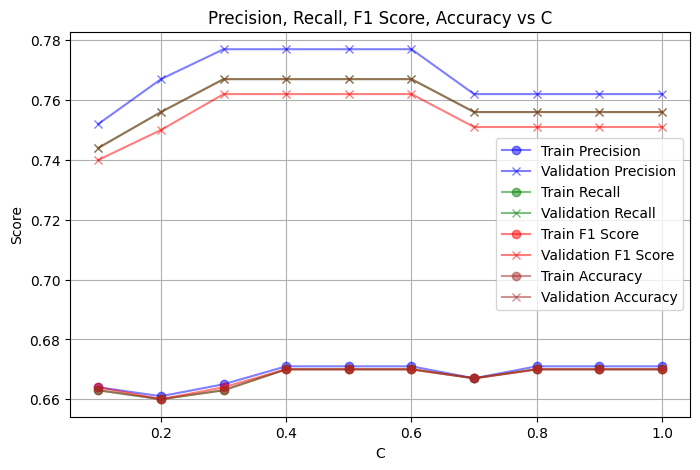

In [417]:
train_precision = grid_df["Train Precision"]
valid_precision = grid_df["Validation Precision"]
train_recall = grid_df["Train Recall"]
train_acc = grid_df["Train Accuracy"]

valid_recall = grid_df["Validation Recall"]
train_f1_score = grid_df["Train F1 Score"]
valid_f1_score = grid_df["Validation F1 Score"]
valid_acc = grid_df["Validation Accuracy"]

create_combined_plot(grid_df["C"], train_precision, valid_precision, train_recall, valid_recall, train_f1_score, valid_f1_score, train_acc, valid_acc, "C")

Best performance is around C = 0.5

Hyperparameters selected for logistic regression:

Number of Iterations: 30

C = 0.5

Solver = lbfgs

### Support Vector Machine (make sure to try using kernels); hyperparameters to explore: C, kernel, degree of polynomial kernel, gamma.

In [418]:
svm_model = SVC()

svm_model.fit(X = X_train, y = y_train)

# Evaluating on training data
train_preds = svm_model.predict(X_train)
print("---------------------- Training Metrics ----------------------")
print("Accuracy: ", round(accuracy_score(y_train, train_preds), 3))
print("Precision: ", precision_score(y_train, train_preds, average = "macro").round(3))
print("Recall: ", recall_score(y_train, train_preds, average = "macro").round(3))
print("F1 Score: ", f1_score(y_train, train_preds, average = "macro").round(3))

# Evaluating on validation data
validate_preds = svm_model.predict(X_validate)
print("---------------------- Validation Metrics ----------------------")
print("Accuracy: ", round(accuracy_score(y_validate, validate_preds), 3))
print("Precision: ", precision_score(y_validate, validate_preds, average = "macro").round(3))
print("Recall: ", recall_score(y_validate, validate_preds, average = "macro").round(3))
print("F1 Score: ", f1_score(y_validate, validate_preds, average = "macro").round(3))

---------------------- Training Metrics ----------------------
Accuracy:  0.737
Precision:  0.74
Recall:  0.737
F1 Score:  0.737
---------------------- Validation Metrics ----------------------
Accuracy:  0.767
Precision:  0.772
Recall:  0.767
F1 Score:  0.768


In [419]:
# Hyper Parameters

cs = [0.001, 0.001, 0.1, 1, 10]
gamma = [round(x * 0.01, 3) for x in range(0, 101, 10)]
kernels = ["linear", "poly", "rbf"]
poly_kernel_degrees = [1, 2, 3]

gamma

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [420]:
svm_grid_df = pd.DataFrame(columns = ["C", "Train Precision", "Train Recall", "Train F1 Score", "Train Accuracy", 
                                  "Validation Precision", "Validation Recall", "Validation F1 Score", "Validation Accuracy"])

for c in cs:

    svm_model = SVC(C = c)

    svm_model.fit(X_train, y_train)

    train_preds = svm_model.predict(X_train)

    train_pr = precision_score(y_train, train_preds, average = "macro").round(3)
    train_rec = recall_score(y_train, train_preds, average = "macro").round(3)
    train_f1_score = f1_score(y_train, train_preds, average = "macro").round(3)
    train_acc = round(accuracy_score(y_train, train_preds,), 3)

    validate_preds = svm_model.predict(X_validate)

    valid_pr = precision_score(y_validate, validate_preds, average = "macro").round(3)
    valid_rec = recall_score(y_validate, validate_preds, average = "macro").round(3)
    valid_f1_score = f1_score(y_validate, validate_preds, average = "macro").round(3)
    valid_acc = round(accuracy_score(y_validate, validate_preds,), 3)

    curr_row = [c, train_pr, train_rec, train_f1_score, train_acc, valid_pr, valid_rec, valid_f1_score, valid_acc]

    svm_grid_df.loc[len(svm_grid_df)] = curr_row

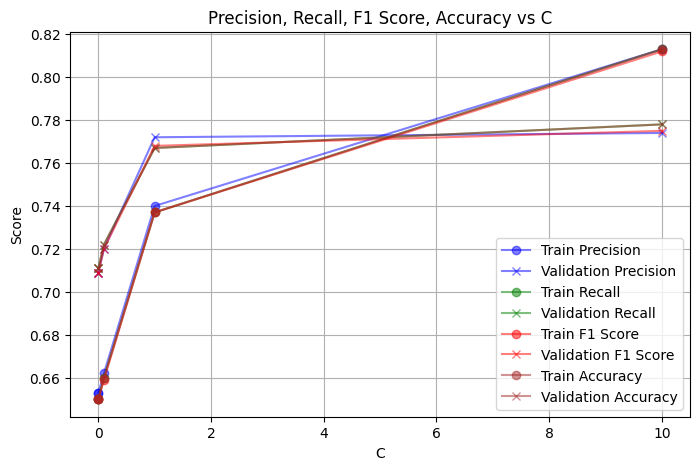

In [421]:
train_precision = svm_grid_df["Train Precision"]
valid_precision = svm_grid_df["Validation Precision"]
train_recall = svm_grid_df["Train Recall"]
train_acc = svm_grid_df["Train Accuracy"]

valid_recall = svm_grid_df["Validation Recall"]
train_f1_score = svm_grid_df["Train F1 Score"]
valid_f1_score = svm_grid_df["Validation F1 Score"]
valid_acc = svm_grid_df["Validation Accuracy"]

create_combined_plot(svm_grid_df["C"], train_precision, valid_precision, train_recall, valid_recall, train_f1_score, valid_f1_score, train_acc, valid_acc, "C")

In [422]:
# Checking Gamma which is for rbf and poly kernels only.

svm_grid_df = pd.DataFrame(columns = ["C", "Gamma", "Train Precision", "Train Recall", "Train F1 Score", "Train Accuracy", 
                                  "Validation Precision", "Validation Recall", "Validation F1 Score", "Validation Accuracy"])

for g in gamma:

    svm_model = SVC(C = 1, gamma = g)

    svm_model.fit(X_train, y_train)

    train_preds = svm_model.predict(X_train)

    train_pr = precision_score(y_train, train_preds, average = "macro").round(3)
    train_rec = recall_score(y_train, train_preds, average = "macro").round(3)
    train_f1_score = f1_score(y_train, train_preds, average = "macro").round(3)
    train_acc = round(accuracy_score(y_train, train_preds,), 3)

    validate_preds = svm_model.predict(X_validate)

    valid_pr = precision_score(y_validate, validate_preds, average = "macro").round(3)
    valid_rec = recall_score(y_validate, validate_preds, average = "macro").round(3)
    valid_f1_score = f1_score(y_validate, validate_preds, average = "macro").round(3)
    valid_acc = round(accuracy_score(y_validate, validate_preds,), 3)

    curr_row = [1, g, train_pr, train_rec, train_f1_score, train_acc, valid_pr, valid_rec, valid_f1_score, valid_acc]

    svm_grid_df.loc[len(svm_grid_df)] = curr_row

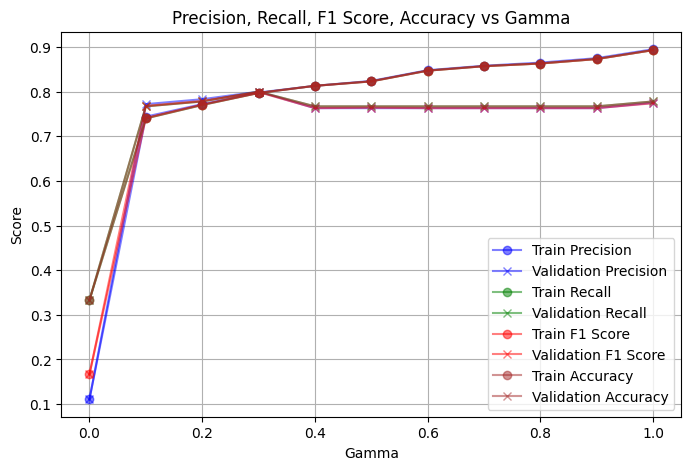

In [423]:
train_precision = svm_grid_df["Train Precision"]
valid_precision = svm_grid_df["Validation Precision"]
train_recall = svm_grid_df["Train Recall"]
train_acc = svm_grid_df["Train Accuracy"]

valid_recall = svm_grid_df["Validation Recall"]
train_f1_score = svm_grid_df["Train F1 Score"]
valid_f1_score = svm_grid_df["Validation F1 Score"]
valid_acc = svm_grid_df["Validation Accuracy"]

create_combined_plot(svm_grid_df["Gamma"], train_precision, valid_precision, train_recall, valid_recall, train_f1_score, valid_f1_score, train_acc, valid_acc, "Gamma")

In [424]:
# Checking different kernels

svm_grid_df = pd.DataFrame(columns = ["C", "Kernel", "Train Precision", "Train Recall", "Train F1 Score", "Train Accuracy", 
                                  "Validation Precision", "Validation Recall", "Validation F1 Score", "Validation Accuracy"])

for k in kernels:

    if k == "linear":
        svm_model = SVC(C = 1, kernel = k)
    else:
        svm_model = SVC(C = 1, kernel = k, gamma = 0.3)

    svm_model.fit(X_train, y_train)

    train_preds = svm_model.predict(X_train)

    train_pr = precision_score(y_train, train_preds, average = "macro").round(3)
    train_rec = recall_score(y_train, train_preds, average = "macro").round(3)
    train_f1_score = f1_score(y_train, train_preds, average = "macro").round(3)
    train_acc = round(accuracy_score(y_train, train_preds,), 3)

    validate_preds = svm_model.predict(X_validate)

    valid_pr = precision_score(y_validate, validate_preds, average = "macro").round(3)
    valid_rec = recall_score(y_validate, validate_preds, average = "macro").round(3)
    valid_f1_score = f1_score(y_validate, validate_preds, average = "macro").round(3)
    valid_acc = round(accuracy_score(y_validate, validate_preds,), 3)

    curr_row = [1, k, train_pr, train_rec, train_f1_score, train_acc, valid_pr, valid_rec, valid_f1_score, valid_acc]

    svm_grid_df.loc[len(svm_grid_df)] = curr_row

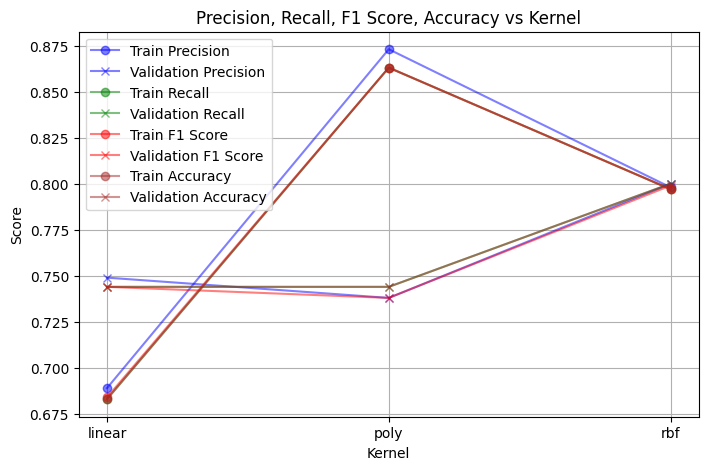

In [425]:
train_precision = svm_grid_df["Train Precision"]
valid_precision = svm_grid_df["Validation Precision"]
train_recall = svm_grid_df["Train Recall"]
train_acc = svm_grid_df["Train Accuracy"]

valid_recall = svm_grid_df["Validation Recall"]
train_f1_score = svm_grid_df["Train F1 Score"]
valid_f1_score = svm_grid_df["Validation F1 Score"]
valid_acc = svm_grid_df["Validation Accuracy"]

create_combined_plot(svm_grid_df["Kernel"], train_precision, valid_precision, train_recall, valid_recall, train_f1_score, valid_f1_score, train_acc, valid_acc, "Kernel")

In [426]:
# Polynomial Kernels

# Checking different kernels

svm_grid_df = pd.DataFrame(columns = ["C", "Kernel", "Degree", "Train Precision", "Train Recall", "Train F1 Score", "Train Accuracy", 
                                  "Validation Precision", "Validation Recall", "Validation F1 Score", "Validation Accuracy"])

for deg in poly_kernel_degrees:

    svm_model = SVC(C = 1, kernel = "poly", gamma = 0.3, degree = deg)

    svm_model.fit(X_train, y_train)

    train_preds = svm_model.predict(X_train)

    train_pr = precision_score(y_train, train_preds, average = "macro").round(3)
    train_rec = recall_score(y_train, train_preds, average = "macro").round(3)
    train_f1_score = f1_score(y_train, train_preds, average = "macro").round(3)
    train_acc = round(accuracy_score(y_train, train_preds,), 3)

    validate_preds = svm_model.predict(X_validate)

    valid_pr = precision_score(y_validate, validate_preds, average = "macro").round(3)
    valid_rec = recall_score(y_validate, validate_preds, average = "macro").round(3)
    valid_f1_score = f1_score(y_validate, validate_preds, average = "macro").round(3)
    valid_acc = round(accuracy_score(y_validate, validate_preds,), 3)

    curr_row = [1, "Polynomial", deg, train_pr, train_rec, train_f1_score, train_acc, valid_pr, valid_rec, valid_f1_score, valid_acc]

    svm_grid_df.loc[len(svm_grid_df)] = curr_row

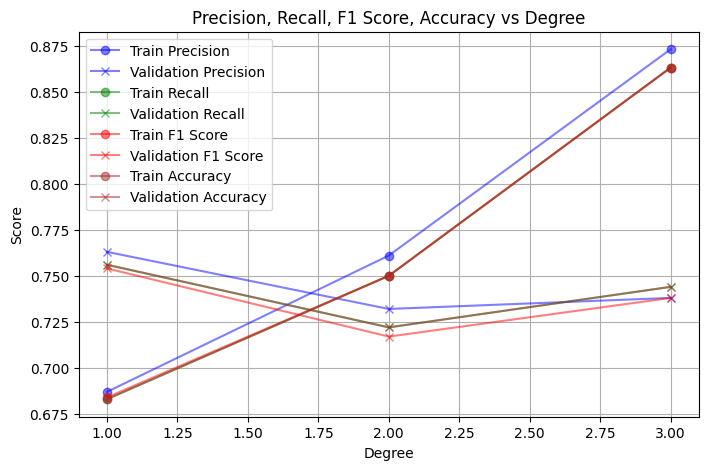

In [427]:
train_precision = svm_grid_df["Train Precision"]
valid_precision = svm_grid_df["Validation Precision"]
train_recall = svm_grid_df["Train Recall"]
train_acc = svm_grid_df["Train Accuracy"]

valid_recall = svm_grid_df["Validation Recall"]
train_f1_score = svm_grid_df["Train F1 Score"]
valid_f1_score = svm_grid_df["Validation F1 Score"]
valid_acc = svm_grid_df["Validation Accuracy"]

create_combined_plot(svm_grid_df["Degree"], train_precision, valid_precision, train_recall, valid_recall, train_f1_score, valid_f1_score, train_acc, valid_acc, "Degree")

Hyperparameters for SVM:

Kernel: RBF

C: 1

Gamma: 0.3

### Random Forest classifier (also analyze feature importance); hyperparameters to explore: the number of trees, max depth, the minimum number of samples required to split an internal node, the minimum number of samples required to be at a leaf node. 

In [428]:
X_pre_defined = np.concatenate((X_train, X_validate), axis=0)
y_pre_defined = np.concatenate((y_train, y_validate), axis=0)

split_index = [-1] * len(X_train) + [0] * len(X_validate)
predefined_split = PredefinedSplit(test_fold = split_index)

param_grid = {
    'n_estimators' : [50, 100, 150, 200],
    'max_depth' : [2, 4, 8, 16, 32],
    'min_samples_split' : [2, 5, 10, 20],
    'min_samples_leaf' : [2, 4, 8, 16, 32, 64]
}

rf = RandomForestClassifier(random_state = 10)

grid_search = GridSearchCV(rf, param_grid, cv = predefined_split, scoring = 'accuracy', verbose = 1)

grid_search.fit(X_pre_defined, y_pre_defined)

best_random_forest = grid_search.best_estimator_

Fitting 1 folds for each of 480 candidates, totalling 480 fits


In [429]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


In [430]:
# Evaluating on training data
train_preds = best_random_forest.predict(X_train)
print("---------------------- Training Metrics ----------------------")
print("Accuracy: ", round(accuracy_score(y_train, train_preds), 3))
print("Precision: ", precision_score(y_train, train_preds, average = "macro").round(3))
print("Recall: ", recall_score(y_train, train_preds, average = "macro").round(3))
print("F1 Score: ", f1_score(y_train, train_preds, average = "macro").round(3))

# Evaluating on validation data
validate_preds = best_random_forest.predict(X_validate)
print("---------------------- Validation Metrics ----------------------")
print("Accuracy: ", round(accuracy_score(y_validate, validate_preds), 3))
print("Precision: ", precision_score(y_validate, validate_preds, average = "macro").round(3))
print("Recall: ", recall_score(y_validate, validate_preds, average = "macro").round(3))
print("F1 Score: ", f1_score(y_validate, validate_preds, average = "macro").round(3))

---------------------- Training Metrics ----------------------
Accuracy:  0.89
Precision:  0.891
Recall:  0.89
F1 Score:  0.89
---------------------- Validation Metrics ----------------------
Accuracy:  0.922
Precision:  0.923
Recall:  0.922
F1 Score:  0.922


In [431]:
feature_imps = list(best_random_forest.feature_importances_)
fi_df = pd.DataFrame(columns = ["Feature", "Importance"])

for itr in range(len(X_train.columns)):
    curr_row = [X_train.columns[itr], feature_imps[itr]]
    fi_df.loc[len(fi_df)] = curr_row

In [432]:
fi_df.sort_values(by = ["Importance"], ascending = False)

,Feature,Importance
4,Physical_layers,0.154484
10,Sandy_texture,0.138821
7,Splotchy_texture,0.113991
0,Angular_fragments,0.111770
5,Veins,0.084969
8,Single_translucent_crystal,0.084039
2,Straight_stripes,0.080928
1,Rounded _fragments,0.075261
6,Oily/shimmery_texture,0.075220
3,Curved_stripes,0.047314


Best Parameter:

Max Depth: 8

Min Samples Leaf: 2

Min Samples Split: 2

Number of Estimators: 50

# Question 5
Combine your classifiers into an ensemble and try to outperform each individual classifier on the validation set. Once you have found a good one, try it on the test set. Describe and discuss your findings.

In [433]:
# Best logistic regression model
best_logreg = LogisticRegression(fit_intercept = True, multi_class = "multinomial", max_iter = 30, solver = "lbfgs", C = 0.5, random_state = 10)
best_logreg.fit(X = X_train, y = y_train)

# Best SVM model
best_svm = SVC(C = 1, kernel = 'rbf', gamma = 0.3, random_state = 10, probability = True)
best_svm.fit(X = X_train, y = y_train)

# Best Random Forest model
# best_random_forest = RandomForestClassifier(random_state = 10, max_depth = 8, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 50)
# best_random_forest.fit(X = X_train, y = y_train)

SVC(C=1, gamma=0.3, probability=True, random_state=10)

In [434]:
models = [("lr", best_logreg), ("svm", best_svm), ("rf", best_random_forest)]

In [435]:
vc_hard = VotingClassifier(estimators = models, voting = 'hard')

vc_hard.fit(X_train, y_train)

# Evaluating on training data
train_preds = vc_hard.predict(X_train)
print("---------------------- Training Metrics ----------------------")
print("Accuracy: ", round(accuracy_score(y_train, train_preds), 3))
print("Precision: ", precision_score(y_train, train_preds, average = "macro").round(3))
print("Recall: ", recall_score(y_train, train_preds, average = "macro").round(3))
print("F1 Score: ", f1_score(y_train, train_preds, average = "macro").round(3))

# Evaluating on validation data
validate_preds = vc_hard.predict(X_validate)
print("---------------------- Validation Metrics ----------------------")
print("Accuracy: ", round(accuracy_score(y_validate, validate_preds), 3))
print("Precision: ", precision_score(y_validate, validate_preds, average = "macro").round(3))
print("Recall: ", recall_score(y_validate, validate_preds, average = "macro").round(3))
print("F1 Score: ", f1_score(y_validate, validate_preds, average = "macro").round(3))

---------------------- Training Metrics ----------------------
Accuracy:  0.81
Precision:  0.812
Recall:  0.81
F1 Score:  0.811
---------------------- Validation Metrics ----------------------
Accuracy:  0.778
Precision:  0.777
Recall:  0.778
F1 Score:  0.776


In [436]:
vc_soft = VotingClassifier(estimators = models, voting = 'soft')

vc_soft.fit(X_train, y_train)

# Evaluating on training data
train_preds = vc_soft.predict(X_train)
print("---------------------- Training Metrics ----------------------")
print("Accuracy: ", round(accuracy_score(y_train, train_preds), 3))
print("Precision: ", precision_score(y_train, train_preds, average = "macro").round(3))
print("Recall: ", recall_score(y_train, train_preds, average = "macro").round(3))
print("F1 Score: ", f1_score(y_train, train_preds, average = "macro").round(3))

# Evaluating on validation data
validate_preds = vc_soft.predict(X_validate)
print("---------------------- Validation Metrics ----------------------")
print("Accuracy: ", round(accuracy_score(y_validate, validate_preds), 3))
print("Precision: ", precision_score(y_validate, validate_preds, average = "macro").round(3))
print("Recall: ", recall_score(y_validate, validate_preds, average = "macro").round(3))
print("F1 Score: ", f1_score(y_validate, validate_preds, average = "macro").round(3))

---------------------- Training Metrics ----------------------
Accuracy:  0.813
Precision:  0.816
Recall:  0.813
F1 Score:  0.814
---------------------- Validation Metrics ----------------------
Accuracy:  0.778
Precision:  0.777
Recall:  0.778
F1 Score:  0.776


In [437]:
comp = {
    "Models" : ["Logistic Regression", "SVM", "Random Forest", "Hard Margin Ensemble", "Soft Margin Ensemble"],
    "Train Precision" : [0.671, 0.798, 0.891, 0.812, 0.816],
    "Train Recall" : [0.67, 0.797, 0.89, 0.81, 0.813],
    "Train F1 Score" : [0.67, 0.797, 0.89, 0.811, 0.813],
    "Train Accuracy" : [0.67, 0.797, 0.89, 0.81, 0.813],
    "Validation Precision" : [0.767, 0.8, 0.922, 0.777, 0.777],
    "Validation Recall" : [0.777, 0.8, 0.923, 0.778, 0.778],
    "Validation F1 Score" : [0.767, 0.8, 0.922, 0.776, 0.776],
    "Validation Accuracy" : [0.762, 0.799, 0.922, 0.778, 0.778],
}

comparison_df = pd.DataFrame(comp)

In [438]:
comparison_df

,Models,Train Precision,Train Recall,Train F1 Score,Train Accuracy,Validation Precision,Validation Recall,Validation F1 Score,Validation Accuracy
0,Logistic Regression,0.671,0.670,0.670,0.670,0.767,0.777,0.767,0.762
1,SVM,0.798,0.797,0.797,0.797,0.800,0.800,0.800,0.799
2,Random Forest,0.891,0.890,0.890,0.890,0.922,0.923,0.922,0.922
3,Hard Margin Ensemble,0.812,0.810,0.811,0.810,0.777,0.778,0.776,0.778
4,Soft Margin Ensemble,0.816,0.813,0.813,0.813,0.777,0.778,0.776,0.778


By looking at the metrics, the best model seems to be the Random Forest classifier. But Soft Margin Ensemble is also giving good results, hence we will generate test predictions with both of them.

In [439]:
# Evaluating on test data
test_preds = best_random_forest.predict(X_test)
print("---------------------- Test Metrics ----------------------")
print("Accuracy: ", round(accuracy_score(y_test, test_preds), 3))
print("Precision: ", precision_score(y_test, test_preds, average = "macro").round(3))
print("Recall: ", recall_score(y_test, test_preds, average = "macro").round(3))
print("F1 Score: ", f1_score(y_test, test_preds, average = "macro").round(3))

---------------------- Test Metrics ----------------------
Accuracy:  0.7
Precision:  0.701
Recall:  0.7
F1 Score:  0.698


In [440]:
# Evaluating on test data
test_preds = vc_soft.predict(X_test)
print("---------------------- Test Metrics ----------------------")
print("Accuracy: ", round(accuracy_score(y_test, test_preds), 3))
print("Precision: ", precision_score(y_test, test_preds, average = "macro").round(3))
print("Recall: ", recall_score(y_test, test_preds, average = "macro").round(3))
print("F1 Score: ", f1_score(y_test, test_preds, average = "macro").round(3))

---------------------- Test Metrics ----------------------
Accuracy:  0.711
Precision:  0.713
Recall:  0.711
F1 Score:  0.71


Soft margin ensemble is working better on the test data.

# Question 6
Is your method better than a human?

In [441]:
human_preds = pd.read_csv("data/trialData.csv")

In [442]:
human_preds.shape

(88547, 12)

In [443]:
human_preds.head()

,subid,block,trial,rocknumber,category,subtype,token,type,catresponse,recresponse,cat_correct,rec_correct
0,A1HUMXQ7SEXD8E,1,1,331,Sedimentary,Bituminous Coal,11,NonparentTraining,Metamorphic,NaN,0,NaN
1,A1HUMXQ7SEXD8E,1,2,398,Sedimentary,Dolomite,14,NonparentTraining,Igneous,NaN,0,NaN
2,A1HUMXQ7SEXD8E,1,3,19,Igneous,Basalt,3,NonparentTraining,Sedimentary,NaN,0,NaN
3,A1HUMXQ7SEXD8E,1,4,338,Sedimentary,Breccia,2,NonparentTraining,Metamorphic,NaN,0,NaN
4,A1HUMXQ7SEXD8E,1,5,60,Igneous,Gabbro,12,NonparentTraining,Sedimentary,NaN,0,NaN


In [444]:
human_preds['block'].value_counts()

block
4    44274
3    14769
2    14755
1    14749
Name: count, dtype: int64

In [445]:
human_preds = human_preds[human_preds["rocknumber"].isin(list(range(1, 481)))]
human_preds.shape

(83627, 12)

In [446]:
train_human_preds = human_preds[human_preds["block"].isin([1, 2, 3])]
test_human_preds = human_preds[human_preds["block"].isin([4])]

In [447]:
train_human_preds.shape

(44273, 12)

In [448]:
test_human_preds.shape

(39354, 12)

In [449]:
print("---------------------- Train Metrics ----------------------")
print(round(train_human_preds["cat_correct"].mean(), 3))

print("---------------------- Test Metrics ----------------------")
print(round(test_human_preds["cat_correct"].mean(), 3))

---------------------- Train Metrics ----------------------
0.56
---------------------- Test Metrics ----------------------
0.598


Accuracy Comparison with the best model which is Soft Voting Classifier:

Soft Margin Ensemble Train Accuracy : 0.813

Human Train Accuracy : 0.56

Soft Margin Ensemble Test Accuracy : 0.711

Human Test Accuracy : 0.598

The soft margin ensemble accuracy does better than humans in accuracy.

In [450]:
data

,Rock Number,Subtype number,Token number,Angular fragments,Rounded fragments,Straight stripes,Curved stripes,Physical layers,Veins,Oily/shimmery texture,Splotchy texture,Single translucent crystal,Multiple cubic crystals,Sandy texture,Label
0,1,1,1,0.596102,0.353480,-0.348062,-0.263005,-0.763119,-0.023358,-0.544358,0.943441,-0.233692,-0.224072,-0.114785,1
1,2,1,2,2.918160,0.353480,-0.348062,-0.263005,-0.532075,-0.510837,-0.544358,-0.246708,-0.233692,0.222213,-0.403855,1
2,3,1,3,2.660153,-0.406238,-0.348062,-0.263005,-0.532075,-0.510837,-0.544358,1.240978,-0.233692,-0.224072,-0.403855,1
3,4,1,4,0.080089,3.898827,-0.348062,-0.263005,-0.532075,-0.510837,-0.544358,-0.246708,-0.233692,-0.224072,-0.114785,1
4,5,1,5,1.370121,3.645588,-0.348062,-0.263005,-0.763119,-0.510837,-0.544358,-0.246708,-0.233692,-0.224072,-0.403855,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,476,30,12,-0.435923,-0.406238,-0.348062,-0.263005,2.009408,-0.023358,-0.544358,-0.841782,-0.233692,-0.224072,1.041495,3
476,477,30,13,-0.435923,-0.406238,-0.348062,-0.263005,1.085232,-0.510837,-0.544358,-0.544245,-0.233692,-0.224072,1.330565,3
477,478,30,14,-0.435923,-0.406238,-0.348062,-0.263005,1.316276,-0.023358,-0.544358,-0.544245,-0.233692,-0.224072,0.463355,3
478,479,30,15,-0.435923,-0.406238,-0.348062,-0.263005,1.085232,0.464121,-0.544358,-0.246708,-0.233692,-0.224072,0.463355,3


In [451]:
human_preds

,subid,block,trial,rocknumber,category,subtype,token,type,catresponse,recresponse,cat_correct,rec_correct
0,A1HUMXQ7SEXD8E,1,1,331,Sedimentary,Bituminous Coal,11,NonparentTraining,Metamorphic,NaN,0,NaN
1,A1HUMXQ7SEXD8E,1,2,398,Sedimentary,Dolomite,14,NonparentTraining,Igneous,NaN,0,NaN
2,A1HUMXQ7SEXD8E,1,3,19,Igneous,Basalt,3,NonparentTraining,Sedimentary,NaN,0,NaN
3,A1HUMXQ7SEXD8E,1,4,338,Sedimentary,Breccia,2,NonparentTraining,Metamorphic,NaN,0,NaN
4,A1HUMXQ7SEXD8E,1,5,60,Igneous,Gabbro,12,NonparentTraining,Sedimentary,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
88541,A2FXYZE13N65FJ,4,1075,247,Metamorphic,Migmatite,7,NonparentTraining,Metamorphic,Yes,1,1.0
88542,A2FXYZE13N65FJ,4,1076,366,Sedimentary,Chert,14,StandardTransfer,Sedimentary,No,1,1.0
88543,A2FXYZE13N65FJ,4,1077,412,Sedimentary,Micrite,12,StandardTransfer,Sedimentary,No,1,1.0
88544,A2FXYZE13N65FJ,4,1078,476,Sedimentary,Shale,12,NonparentTraining,Metamorphic,Yes,0,1.0


In [452]:
human_preds["rocknumber"].value_counts()

rocknumber
389    329
129    329
51     329
34     329
103    329
      ... 
373     82
111     82
94      81
191     81
6       81
Name: count, Length: 480, dtype: int64